Import libs

In [40]:
%matplotlib inline

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import cv2
import os
import glob
from sklearn.model_selection import train_test_split

# For CNN
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.applications.vgg16 import VGG16

In [27]:
IMAGE_SIZE = 224

In [29]:
img_dir = "/car-plate-detection/images" # Enter Directory of all images 
data_path = os.path.join(img_dir,'*g')
files = glob.glob(data_path)
files.sort()
X=[]
for f1 in files:
    img = cv2.imread(f1)
    img = cv2.resize(img, (IMAGE_SIZE,IMAGE_SIZE))
    X.append(np.array(img))
    

In [30]:
from lxml import etree
def resizeannotation(f):
    tree = etree.parse(f)
    for dim in tree.xpath("size"):
        width = int(dim.xpath("width")[0].text)
        height = int(dim.xpath("height")[0].text)
    for dim in tree.xpath("object/bndbox"):
        xmin = int(dim.xpath("xmin")[0].text)/(width/IMAGE_SIZE)
        ymin = int(dim.xpath("ymin")[0].text)/(height/IMAGE_SIZE)
        xmax = int(dim.xpath("xmax")[0].text)/(width/IMAGE_SIZE)
        ymax = int(dim.xpath("ymax")[0].text)/(height/IMAGE_SIZE)
    return [int(xmax), int(ymax), int(xmin), int(ymin)]
        

In [32]:
path = '../input/car-plate-detection/annotations'
xml_files = ['../input/car-plate-detection/annotations/'+f for f in sorted(os.listdir(path))]
y=[]
for i in text_files:
    y.append(resizeannotation(i))

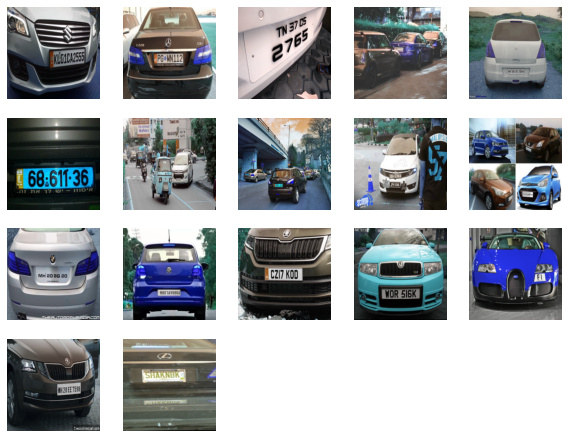

In [33]:
plt.figure(figsize=(10,20))
for i in range(0,17) :
    plt.subplot(10,5,i+1)
    plt.axis('off')
    plt.imshow(X[i])

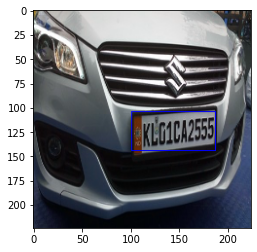

In [34]:
#Example with the first image of the dataset
image = cv2.rectangle(X[0],(y[0][0],y[0][1]),(y[0][2],y[0][3]),(0, 0, 255))
plt.imshow(image)
plt.show()


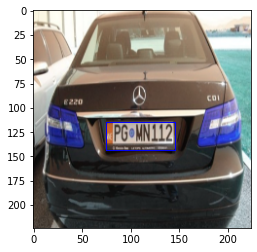

In [35]:
#Example with the second image of the dataset
image = cv2.rectangle(X[1],(y[1][0],y[1][1]),(y[1][2],y[1][3]),(0, 0, 255))
plt.imshow(image)
plt.show()


Подготовим данные для CNN :

In [36]:
X=np.array(X)
y=np.array(y)

In [37]:
#Renormalisation
X = X / 255
y = y / 255

Разбиение данных для train и validation

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=1)

## Convolutionnal Neural Network

Создаем CNN сеть 

In [43]:
model = Sequential()
model.add(VGG16(weights="imagenet", include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))
model.add(Flatten())
model.add(Dense(128, activation="relu"))
model.add(Dense(128, activation="relu"))
model.add(Dense(64, activation="relu"))
model.add(Dense(4, activation="sigmoid"))

# model.layers[-6].trainable = False

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_3 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_12 (Dense)             (None, 128)               3211392   
_________________________________________________________________
dense_13 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_14 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_15 (Dense)             (None, 4)                 260       
Total params: 17,951,108
Trainable params: 17,951,108
Non-trainable params: 0
__________________________________________

In [44]:
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])

In [45]:
train = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=30, batch_size=32, verbose=1)

Epoch 1/30
10/10 [==============================] - 305s 30s/step - loss: 0.0766 - accuracy: 0.4286 - val_loss: 0.0381 - val_accuracy: 0.4571
Epoch 2/30
10/10 [==============================] - 304s 30s/step - loss: 0.0352 - accuracy: 0.5682 - val_loss: 0.0244 - val_accuracy: 0.4571
Epoch 3/30
10/10 [==============================] - 304s 30s/step - loss: 0.0243 - accuracy: 0.5570 - val_loss: 0.0258 - val_accuracy: 0.4571
Epoch 4/30
10/10 [==============================] - 303s 30s/step - loss: 0.0245 - accuracy: 0.5469 - val_loss: 0.0237 - val_accuracy: 0.4571
Epoch 5/30
10/10 [==============================] - 302s 30s/step - loss: 0.0217 - accuracy: 0.5593 - val_loss: 0.0236 - val_accuracy: 0.4571
Epoch 6/30
10/10 [==============================] - 302s 30s/step - loss: 0.0199 - accuracy: 0.5709 - val_loss: 0.0261 - val_accuracy: 0.4571
Epoch 7/30
10/10 [==============================] - 303s 30s/step - loss: 0.0224 - accuracy: 0.5679 - val_loss: 0.0247 - val_accuracy: 0.4571
Epoch 

In [47]:
model.save('cnn_w.h5', overwrite=True) 

In [48]:
# Test
scores = model.evaluate(X_test, y_test, verbose=0)
print("Score : %.2f%%" % (scores[1]*100))

Score : 75.86%


In [50]:
def plot_scores(train) :
    accuracy = train.history['accuracy']
    val_accuracy = train.history['val_accuracy']
    epochs = range(len(accuracy))
    plt.plot(epochs, accuracy, 'b', label='Score apprentissage')
    plt.plot(epochs, val_accuracy, 'r', label='Score validation')
    plt.title('Scores')
    plt.legend()
    plt.show()

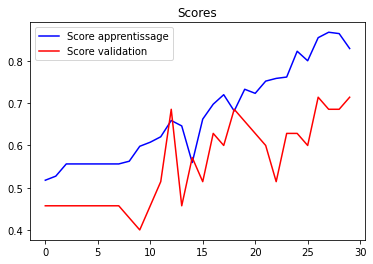

In [51]:
plot_scores(train)

## DETECTION 

In [52]:
test_loss, test_accuracy = model.evaluate(X_test, y_test,steps=int(100))

print("Test results \n Loss:",test_loss,'\n Accuracy',test_accuracy)


100/100 [==============================] - 24s 235ms/step - loss: 0.0107 - accuracy: 0.7586
Test results 
 Loss: 0.010741328820586205 
 Accuracy 0.7586206793785095


In [53]:
 y_cnn = model.predict(X_test)

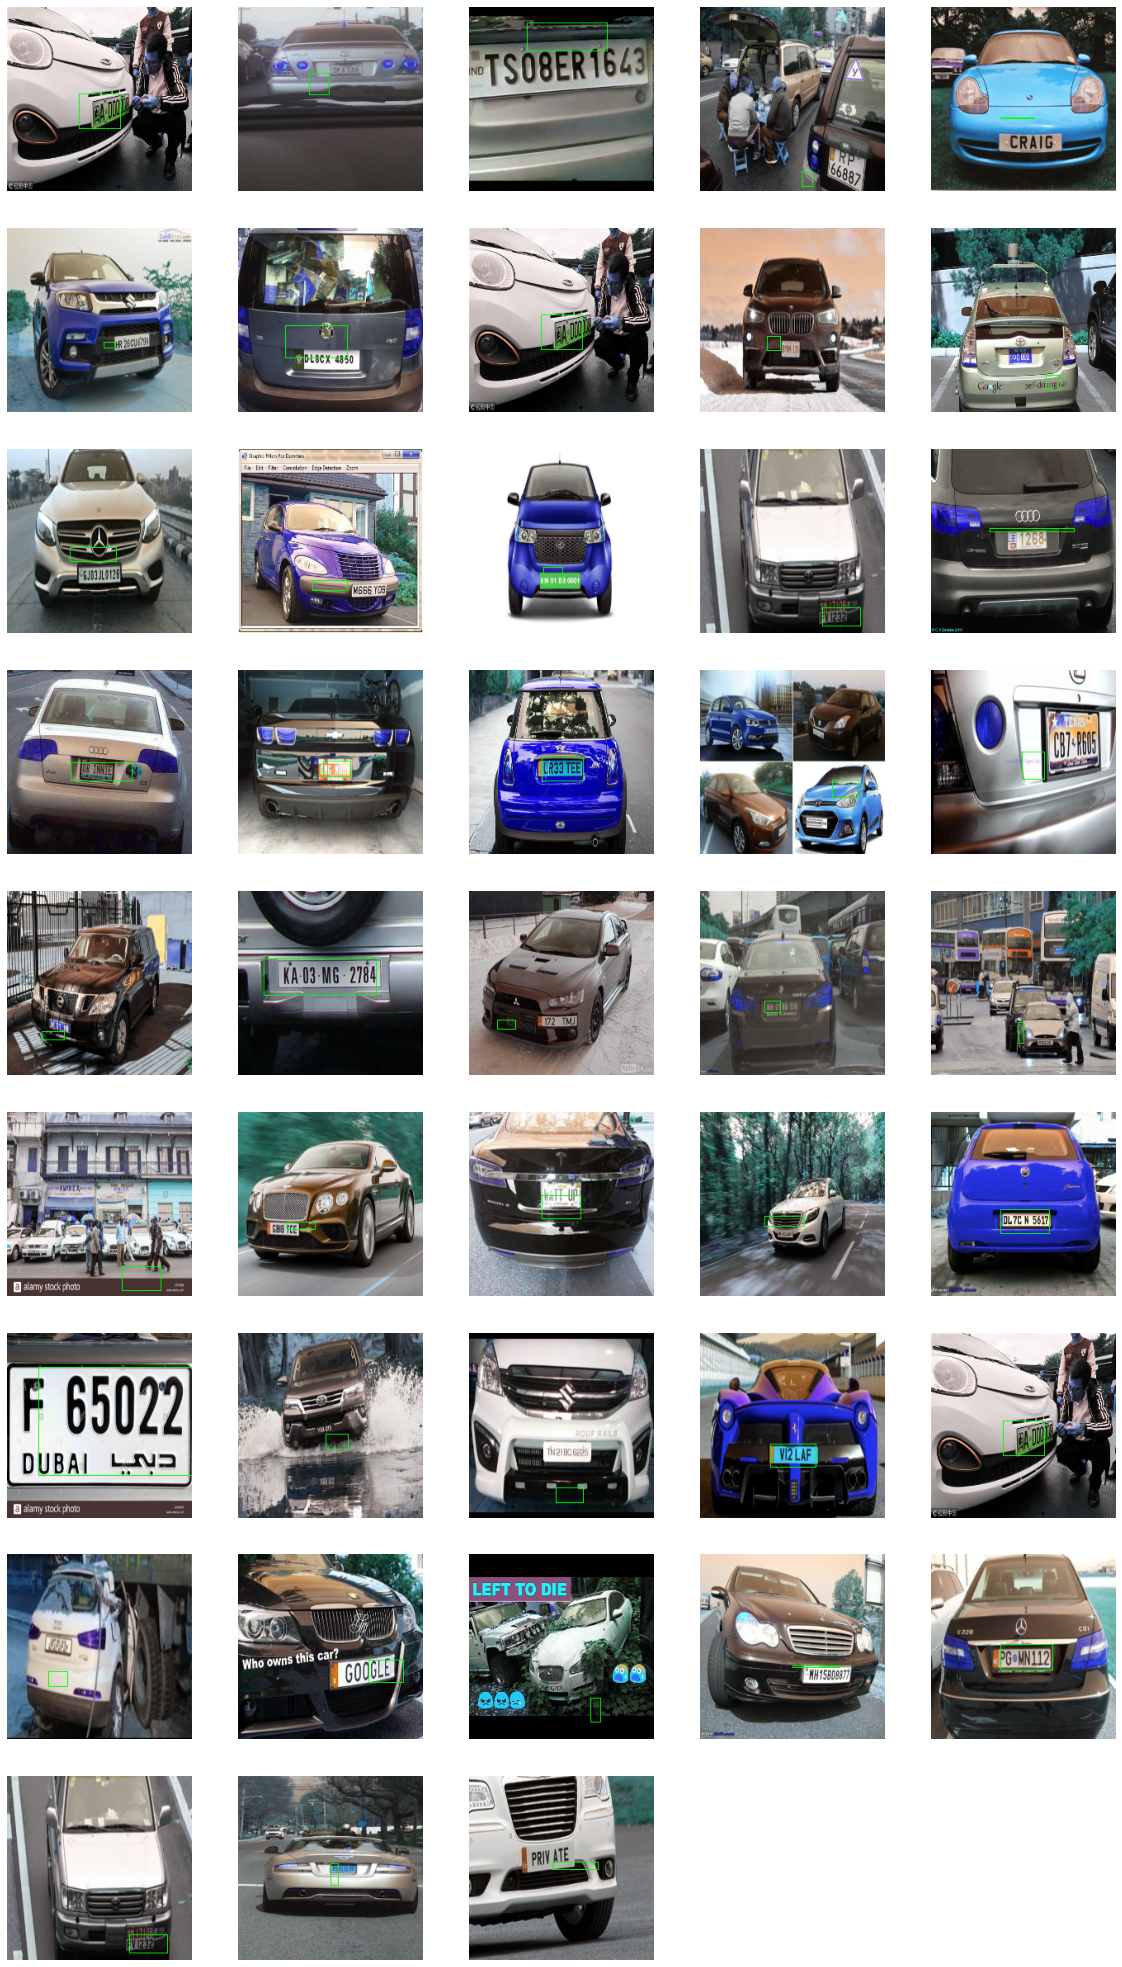

In [54]:
plt.figure(figsize=(20,40))
for i in range(0,43) :
    plt.subplot(10,5,i+1)
    plt.axis('off')
    ny = y_cnn[i]*255
    image = cv2.rectangle(X_test[i],(int(ny[0]),int(ny[1])),(int(ny[2]),int(ny[3])),(0, 255, 0))
    plt.imshow(image)

